<a href="https://colab.research.google.com/github/s97clinton/s97clinton/blob/main/Fine_Tuning_RoBERTa_Model_on_UCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The plan for fine-tuning RoBERTA with the UCC
## 1. Set Up


*   Install transformers and pytorch lightning and import required packages.
*   Load UCC data and inspect.

## 2. Create a dataset


*   Load data into PyTorch dataset.

## 3. Build the model


*   Create a new pytorch (lightning) model with the Hugging Face RoBERTa model and a multi-label classification head.

## 4. Test model performance


*   Test model performance using the ROC AUC and same test-set used in the original paper.









# Setup

In [1]:
# !nvidia-smi #Check GPU type
%%capture
!pip install transformers
!pip install pytorch-lightning

In [2]:
import os
import matplotlib.pyplot
from google.colab import drive

In [3]:
drive.mount('/content/drive',force_remount=False)

Mounted at /content/drive


In [4]:
train_path = '/content/drive/MyDrive/corpus/train.csv'
test_path = '/content/drive/MyDrive/corpus/test.csv'
val_path = '/content/drive/MyDrive/corpus/val.csv'

In [5]:
import pandas as pd
train_data = pd.read_csv(train_path)

In [6]:
train_data

,_unit_id,_trusted_judgments,comment,antagonize,antagonize:confidence,condescending,condescending:confidence,dismissive,dismissive:confidence,generalisation,generalisation:confidence,generalisation_unfair,generalisation_unfair:confidence,healthy,healthy:confidence,hostile,hostile:confidence,sarcastic,sarcastic:confidence
0,2319157561,4,"Three marriages, several bankrupt periods, inh...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7578,0,0.7565,0,1.0000
1,1739464982,4,The sense of entitlement among high school 'jo...,0,0.7634,0,0.7634,0,0.7634,0,1.0000,0.0,1.0,1,0.7634,0,0.7634,0,0.7634
2,1739457583,5,So what? He was just stating the obvious.,0,0.8121,0,0.5928,0,0.8043,0,1.0000,0.0,1.0,1,0.6163,0,1.0000,0,1.0000
3,2319156950,40,"If one is a Con, why yes, one would honk. Loud...",0,0.8508,0,0.8867,0,0.9239,0,0.8863,0.0,1.0,1,0.8508,0,0.9641,0,0.8868
4,2327196492,3,Ooohhh... It's Wendy Whiner... making sure to ...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35498,2327179313,3,"Okay, make that ""write a book"" Fingers don't a...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000
35499,2164631772,3,"It was Americans in Alberta, not the governmen...",0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000
35500,1739460377,3,Whiner: Your air force consists of paper power...,0,1.0000,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,1.0000,0,1.0000,0,1.0000
35501,1739461160,5,OUTSTANDING EDITORIAL!,0,0.7934,0,1.0000,0,1.0000,0,1.0000,0.0,1.0,1,0.7934,0,1.0000,0,1.0000


# Inspect Data

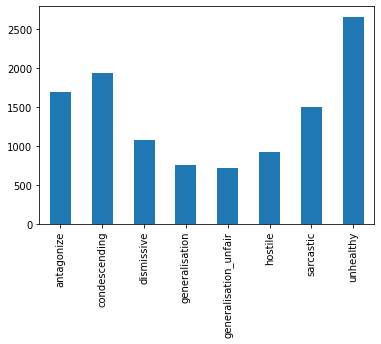

In [7]:
import numpy as np

train_data['unhealthy'] = np.where(train_data['healthy'] == 1, 0, 1)

attributes = ['antagonize','condescending','dismissive','generalisation',
              'generalisation_unfair','hostile','sarcastic','unhealthy']

train_data[attributes].sum().plot.bar()

#Dataset

In [8]:
from torch.utils.data import Dataset
import torch

In [18]:
class UCC_Dataset(Dataset):

  def __init__(self, data_path, tokenizer, attributes, max_token_len: int = 128, sample = 5000):
    self.data_path = data_path
    self.tokenizer = tokenizer
    self.attributes = attributes
    self.max_token_len = max_token_len
    self.sample = sample
    self._prepare_data()

  def _prepare_data(self):
    data = pd.read_csv(self.data_path)
    data['unhealthy'] = np.where(data['healthy'] == 1, 0, 1)
    if self.sample is not None:
      unhealthy = data.loc[data[attributes].sum(axis=1)>0]
      healthy = data.loc[data[attributes].sum(axis=1)==0]
      self.data = pd.concat([unhealthy, healthy.sample(self.sample, random_state = 7)])

    else:
      self.data = data
  

  def __len__(self):
    return(len(self.data))

  def __getitem__(self, index):
    item = self.data.iloc[index]
    comment = str(item.comment)
    attributes = torch.FloatTensor(item[self.attributes])
    tokens = self.tokenizer.encode_plus(comment, 
                                        add_special_tokens=True, 
                                        return_tensors = 'pt', 
                                        truncation = True, 
                                        max_length = self.max_token_len, 
                                        padding = 'max_length',
                                        return_attention_mask = True)
    return {'input_ids': tokens.input_ids.flatten(), 'attention_mask': tokens.attention_mask.flatten(), 'labels': attributes}

In [19]:
from transformers import AutoTokenizer
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
ucc_ds = UCC_Dataset(train_path, tokenizer, attributes)
ucc_ds_val = UCC_Dataset(val_path, tokenizer, attributes, sample = None)

In [20]:
ucc_ds.__getitem__(0)

{'input_ids': tensor([    0, 19897, 29846,     4,    38,    64,    75,   679, 46301,    74,
          9802,   132,     9,    39,   308,    95,     7,  1471,   559,   332,
             8,   146,  7064,   356,  1099,     4,   370,   214,   235,     6,
         46301,    16,    10, 34759,     4,     2,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [21]:
len(ucc_ds)

9960

#Data Module

In [22]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

In [28]:
class UCC_Data_Module(pl.LightningDataModule):

  def __init__(self, train_path, val_path, test_path, attributes, batch_size: int = 16, max_token_len: int = 128, model_name = 'roberta-base'):
    super().__init__()
    self.train_path = train_path
    self.val_path = val_path
    self.test_path = test_path
    self.attributes = attributes
    self.batch_size = batch_size
    self.max_token_len = max_token_len
    self.model_name = model_name
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)


  def setup(self, stage = None):
    if stage in (None, "fit"):
      self.train_dataset = UCC_Dataset(self.train_path, self.tokenizer, self.attributes)
      self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample = None)
    if stage == 'predict':
      self.val_dataset = UCC_Dataset(self.val_path, self.tokenizer, self.attributes, sample = None)
    
  def train_dataloader(self):
    return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=2, shuffle=True)
    
  def val_dataloader(self):
    return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)
    
  def test_dataloader(self):
    return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=2, shuffle=False)

In [29]:
ucc_data_module = UCC_Data_Module(train_path, val_path, test_path, attributes)

In [30]:
ucc_data_module.setup()

In [31]:
d1 = ucc_data_module.train_dataloader()

In [33]:
len(d1)

623

#Model

#Train

#Predict / Evaluate